In [63]:
import pandas as pd
from sqlalchemy import create_engine

# Connect to Postgres and read the agg_salesforce_duns_eds table that was
# created by the DBT job.
engine = create_engine("postgresql://maca@postgres:5432/maca")
salesforce_opportunities = pd.read_sql_query(
    sql="select * from agg_salesforce_duns_eda",
    con=engine
)

# Don't show large float numbers in scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

salesforce_opportunities.head(5)

,account_id,opportunity_name,close_date,stage,amount,lead_source,description,probability,created_date,owner_name,account_name,duns_number,revenue,employee_count,founded_date
0,1,sodales scelerisque mauris sit amet eros suspe...,2022-02-19,Closed Lost,Dinar,Purchased List,Nullam porttitor lacus at turpis. Donec posuer...,15.990,2022-08-29,Chance Arnoult,Eamia,46-532-2344,570839924.730,1875,1901-11-08
1,2,posuere metus vitae ipsum aliquam non mauris m...,2022-12-22,Closed Lost,Euro,Referral,"Lorem ipsum dolor sit amet, consectetuer adipi...",72.600,2022-07-21,Urson MacCollom,Trilith,59-893-5057,238062388.540,2284,1919-01-22
2,3,pharetra magna ac consequat metus sapien ut nu...,2022-12-07,Closed Won,Tugrik,Partner,Morbi porttitor lorem id ligula. Suspendisse o...,25.280,2022-12-22,Alisa D'Oyly,Yambee,42-869-7380,600128427.660,3769,1906-01-16
3,4,sit amet sapien dignissim vestibulum vestibulu...,2022-02-14,Closed Won,Rial,Referral,"Sed sagittis. Nam congue, risus semper porta v...",50.470,2022-10-22,Katrine Harwick,Oyope,51-210-8577,533203683.380,706,2000-07-25
4,5,nulla ut erat id mauris vulputate elementum nu...,2022-03-29,Closed Lost,Yuan Renminbi,Referral,In quis justo. Maecenas rhoncus aliquam lacus....,4.680,2022-09-10,Allyn Rysom,Npath,87-140-6871,952297256.290,46,1940-09-21


[Text(0.5, 1.0, 'Observed Effect of Employee Count on Won vs Lost Opportunities')]

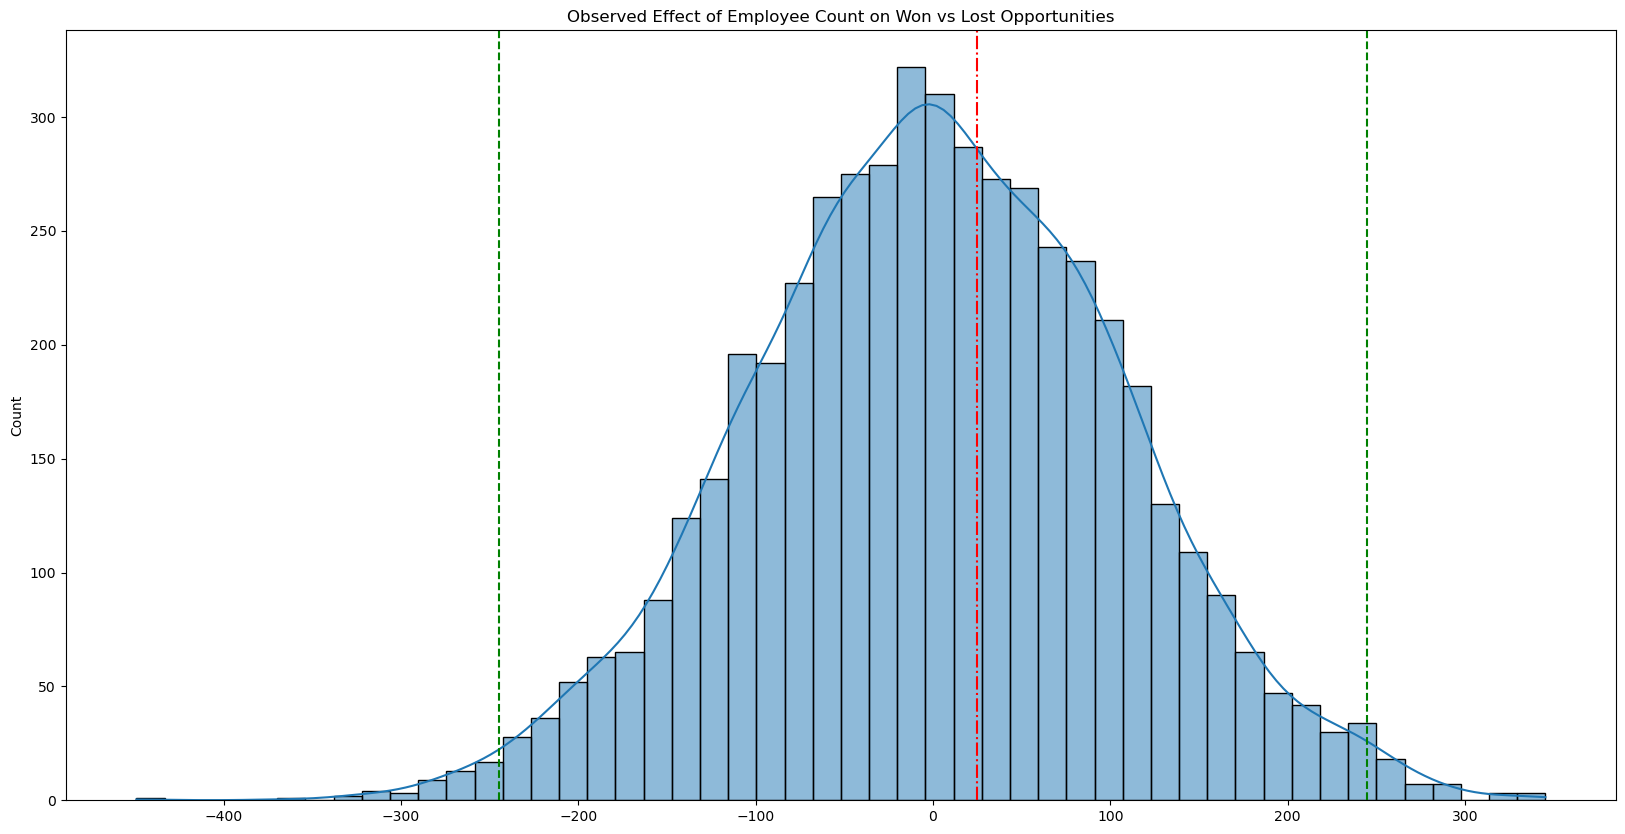

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Compare the impact of employee count on winning or losing an opportunity

closed_won_revenue = salesforce_opportunities[salesforce_opportunities.stage == "Closed Won"].employee_count
closed_lost_revenue = salesforce_opportunities[salesforce_opportunities.stage == "Closed Lost"].employee_count


observed_mean_difference = np.mean(closed_won_revenue) - np.mean(closed_lost_revenue)
null_observation = np.concatenate((closed_won_revenue, closed_lost_revenue))


def resample(input_array, output_size, n):
    
    sample_mean_differences = []
    
    for i in range(n):
        # Shuffle the null_observation array using numpy suffle method
        np.random.shuffle(input_array)

        resample_A, resample_B = input_array[:output_size], input_array[output_size:]

        sample_mean_differences.append(np.mean(resample_A) - np.mean(resample_B))
    
    return sample_mean_differences

sample_mean_differences = resample(
    input_array=null_observation,
    output_size=len(closed_won_revenue),
    n=5000
)

significance_cutoff = np.percentile(
    sample_mean_differences, 99
)

plt.figure(figsize=(20,10))

plot = sns.histplot( 
    x=sample_mean_differences,
    kde=True,
    bins=50,
    log_scale=False
)

plot.axvline(
    x=observed_mean_difference, 
    color='red', 
    linestyle='-.'
)

plot.axvline(
    x=significance_cutoff, 
    color='green', 
    linestyle='--'
)

plot.axvline(
    x=-significance_cutoff, 
    color='green', 
    linestyle='--'
)

plot.set(title='Observed Effect of Employee Count on Won vs Lost Opportunities')
